In [1]:
import sys
plist = ['/Applications/NEURON/lib/python']
for pd in plist:
    if pd in sys.path:
        sys.path.remove(pd)

In [2]:
from neuron import h, rxd
from neuron.units import nM, uM
import matplotlib.pyplot as plt 
import numpy as np

h.load_file('stdrun.hoc')

soma = h.Section(name='soma')
soma.L = soma.diam = 25
soma.nseg = 1

dend = h.Section(name='dend')
dend.L = 20  
dend.diam = 5
dend.nseg = 101
dend.connect(soma)

dend

In [3]:
N = 5   

shells = []
border = []
for i in range(N-1):
    shells.append(rxd.Region(h.allsec(), name='shell%i' % i,
                  geometry=rxd.Shell(float(i)/N, (1.0+i)/N)))
    border.append(rxd.Region(h.allsec(), name='border%i' % i,
                  geometry=rxd.FixedPerimeter(2.0*h.PI*(1.0+i))))

shells.append(rxd.Region(h.allsec(), nrn_region='i', name='shell%i' % N,
                  geometry=rxd.Shell((N-1.0)/N, 1.0)))

In [4]:
Dca = 0.6

mM_to_mol_per_um = 6.0221409e+23 * 1e-18

ca = rxd.Species(shells, d=Dca, name='ca', charge=2, initial=lambda nd: 
                 1.0 * uM if 9.5 < nd.x3d - soma.L < 10.5 and nd.region == shells[-1] else 60 * nM)

In [5]:
cas = []
for reg in shells:
    cas.append(ca[reg])

diffusions = []
for i in range(N-1):
    diffusions.append(rxd.MultiCompartmentReaction(cas[i], cas[i+1], mM_to_mol_per_um*Dca,mM_to_mol_per_um*Dca, border=border[i]))

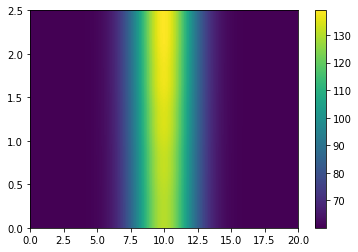

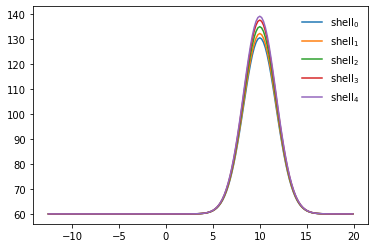

In [6]:
h.finitialize(-65)
h.continuerun(2.5)

plt.figure()
plt.imshow(np.array(ca.nodes(dend).concentration).reshape(N,dend.nseg) / nM,
              origin='lower', extent=(0, dend.L, 0, dend.diam/2.0),
              aspect='auto')
plt.colorbar()

plt.figure()
for i,shell in enumerate(shells):
    plt.plot([nd.x3d - soma.L for nd in ca.nodes(shell)],
                [nd.concentration / nM for nd in ca.nodes(shell)], label="shell$_%i$" % i)
plt.legend(frameon=False)